Variational formulation of Euler's elastica.

In [ ]:
import autograd as ag
import autograd.numpy as np
from scipy import optimize as op
from scipy import interpolate as ip
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
from itertools import chain

def apply_along_axis(func1d, axis, arr, *args, **kwargs):
    # If arr is already one dimensional, just apply func1d directly
    if arr.ndim <= 1:
        return func1d(arr,  *args, **kwargs)
    
    # Extract shape and dimensions of arr for indexing
    dims = arr.shape
    Ni, Nk = dims[:axis],dims[axis+1:]
    # Obtain shape of output of func1d by running it through the first slice
    # along designated axis
    arr_view = arr.swapaxes(-1,axis)
    Nj_new = func1d(arr_view[(0,)*(len(arr_view.shape)-1)][:], *args, **kwargs).shape
    # Generate new array by applying the function using index magic
    func1d_arr = np.array([func1d(arr[ii + (slice(None,None,None),) + kk], *args, **kwargs) for ii in np.ndindex(Ni) for kk in np.ndindex(Nk)]).reshape( Ni + Nk + Nj_new )
    # Reorder to get the same ordering as arr. axis is now replaced by func1d_dim
    # new axes in its original position.
    order = tuple(range(len(func1d_arr.shape)))
    reordering_list = [order[:axis], order[axis:len(dims)-1], order[len(dims)-1:]]
    reordering_list[-1], reordering_list[1] = reordering_list[1], reordering_list[-1]
    return func1d_arr.transpose(tuple(chain.from_iterable(reordering_list)))

Construction of a container for all needed parameters and definition of paramaters

In [3]:
# EI      = bending stiffness
# L       = beam length   
# n_dim   = dimension of the problem 
# n_nodes = number of nodes
Param = namedtuple('Param', ('EI', 'L', 'n_dim', 'n_nodes'))
param = Param(EI = 10, L = 3.3, n_dim = 2, n_nodes = 1001)

# space step
s_step = param.L/(param.n_nodes-1)

In [4]:
# initial and final slopes
theta_in = np.pi/3 # initial tangent angle
theta_end = np.pi/2 # final tangent angle

Nt = 2 # number of equilibrium trajectories
N = np.linspace(theta_in,theta_end,Nt)

Definition of the augmented Lagrangian and its discretisation

In [5]:
def Lagrangian(q,v,a,param):
    return 0.5 *param.EI* np.sum(a**2,axis=0) # axis=0 if the first dim gives me the dimension of the problem !!

def arclength(v,Lamdba,param):
    return Lamdba*(np.sum(v**2,axis=0)-1) # no axial strain

In [6]:
# discretisation of the Lagrangian
def discrete_L(qk,vk,qkp1,vkp1,param):
    ak = ((-2*vkp1-4*vk)*s_step + 6*(qkp1-qk))/s_step**2
    akp1 = ((4*vkp1+2*vk)*s_step - 6*(qkp1-qk)) /s_step**2
    Ld_k = Lagrangian(qk,vk,ak,param)
    Ld_kp1 = Lagrangian(qkp1,vkp1,akp1,param)
    return 0.5*s_step*(Ld_k+Ld_kp1)

def discrete_arclength(vk,lambdak,param):
    return arclength(vk,lambdak,param)

In [7]:
# functions for working on QVL array

def inflateQVL(QVL_flat, param, length=param.n_nodes):
    # from ((n_dim*2 + 1)*n_nodes) array to (n_dim*2 + 1, n_nodes) array
    return QVL_flat.reshape(param.n_dim*2 + 1, length, order='F')

def separateQVL(QVL, param):
    # it separates QVL into two arrays, QV (n_dim, 2, n_nodes) [dimension, q or v, node]
    # and Lambda (n_nodes).
    return (QVL[0:-1,:].reshape(param.n_dim,2,param.n_nodes,order='F'), QVL[-1,:])

def joinQVL(QV, Lambda, param):
    # it joins QV (n_dim, 2, n_nodes) and Lambda (n_nodes) into a QVL
    # (n_dim*2 + 1, n_nodes) array.
    return np.vstack((QV.reshape(param.n_dim*2,param.n_nodes,order='F'),Lambda))

For generating the data sets mentioned in celledoni2023neural, choose:
- 'datacase == 1' for varying the angle of the tangents at both ends
- 'datacase == 2' for varying the angle of the tangent at the right end only

In [8]:
#set boundary conditions [qx,qy] [vx,vy]
Q0 = np.array([0,0]) # fixed intial position 
Qn = np.array([3,0]) # fixed final position

V0 = np.zeros((np.size(N),param.n_dim))
Vn = np.zeros((np.size(N),param.n_dim))

datacase = input("Choose datacase ")
datacase = int(datacase)

if datacase == 1: # both-ends
    for i in range(np.size(N)):
        V0[i,:] = np.array([np.cos(N[i]),np.sin(N[i])]) 
        Vn[i,:] = np.array([np.cos(N[i]),-np.sin(N[i])]) 
elif datacase == 2: # right-end
    for i in range(np.size(N)):
        V0[i,:] = ([np.cos(0),np.sin(0)])
        Vn[i,:] = np.array([np.cos(N[i]),-np.sin(N[i])])

new discrete Lagrangian with 1d-array input

In [9]:
def oneD_Ld(QVL_flat,param):
    QV = separateQVL(inflateQVL(QVL_flat, param, param.n_nodes), param)[0]
    Qk = QV[:,0,0:-1]
    Vk = QV[:,1,0:-1]
    Qkp1 = QV[:,0,1:]
    Vkp1 = QV[:,1,1:]
    return discrete_L(Qk,Vk,Qkp1,Vkp1,param)

def oneD_arclen(QVL_flat,param):
    QV, Lambda = separateQVL(inflateQVL(QVL_flat, param, param.n_nodes), param)
    Vk = QV[:,1,1:-1] # Only inner nodes necessary
    Lambdak = Lambda[1:-1] # Only inner nodes necessary
    return discrete_arclength(Vk,Lambdak,param)

Complete action Sd

In [10]:
def complete_Sd(QVL_flat, param):
    Ld_all = np.sum(apply_along_axis(oneD_Ld, 0, QVL_flat, param))
    gl_all = np.sum(oneD_arclen(QVL_flat, param))
    return Ld_all + gl_all

In [11]:
def separateBC(QVL):
    # it separates the BCs from QVL
    return QVL[:, 1:-1], np.vstack((QVL[:, 0], QVL[:, -1])).transpose()

def joinBC(QVL1, QVLbound, param):
    # it joins BCs to QVL1
    return np.hstack((QVLbound[:,0, None], QVL1, QVLbound[:,-1, None]))

Discrete Euler-Lagrange equations

In [12]:
def DEL(QVL1_flat, QVLbound_flat, param):
    QVL1 = inflateQVL(QVL1_flat, param, param.n_nodes-2)
    QVLbound = inflateQVL(QVLbound_flat, param, 2)
    return ag.grad(lambda y: complete_Sd(joinBC(y, QVLbound, param).flatten(order='F'),param))(QVL1).flatten(order='F')

# Jacobian of the discrete Euler-Lagrange equations
def DEL_automatic_jacobian(QVL1_flat, QVLbound_flat, param):
    return ag.jacobian(lambda y: DEL(y,QVLbound_flat,param))(QVL1_flat)

Partial action: sum of the Lds along the beam minus BCs

In [13]:
def bending_Sd_bc(QVL1_flat,QVLbound_flat,param):
    QVL1 = inflateQVL(QVL1_flat, param, param.n_nodes-2)
    QVLbound = inflateQVL(QVLbound_flat, param, 2)
    QVL_flat = joinBC(QVL1,QVLbound,param).flatten(order='F')
    Ld_all = np.sum(apply_along_axis(oneD_Ld, 0, QVL_flat, param))
    return Ld_all

# constraints
def con(QVL1_flat,param):
    QVL1 = inflateQVL(QVL1_flat,param,param.n_nodes-2)
    # a1 = inflateQV(a1_flat, param, param.n_nodes-2)
    # abound = inflateQVL(a_flat, param, 2)
    return np.sum(QVL1[2:4,:]**2,axis=0)-1

cons = {'type':'eq', 'fun':con, 'args':(param,)}

Solution of the system

In [14]:
coord = np.linspace(0,(param.n_nodes-1)*s_step,param.n_nodes) # array of spatial coordinate
trajectories1 = np.zeros((np.size(N),2*param.n_dim*param.n_nodes)) # collect solutions
cvsplines = np.zeros((np.size(N),2*param.n_dim*param.n_nodes)) # collect cubic slpines
Lambda = np.zeros((np.size(N),param.n_nodes)) # array of Lagrange multiplier
sol_min_matrix = np.zeros((np.size(N),2*param.n_dim*param.n_nodes)) # collect solutions of min(Sd)

for i in range(np.size(N)):
    
    # initial guess
    # intialize QV array using spline interpolation
    Qspline = ip.CubicSpline((0,(param.n_nodes-1)*s_step), (Q0,Qn), bc_type=((1,V0[i,:]),(1,Vn[i,:])))
    Vspline = Qspline.derivative()
    QV = np.hstack((Qspline(coord),Vspline(coord))).transpose()
    
    cvsplines[i,:] = QV.flatten(order='F')
    QVL = joinQVL(QV,Lambda[i,:],param)
    
    QVL1, QVLbound  = separateBC(QVL)
    
    # solution of min(Sd)
    sol_min = op.minimize(bending_Sd_bc,QVL1.flatten(order='F'),args=(QVLbound.flatten(order='F'),param,),method='trust-constr',constraints=cons, options = {'maxiter': 10000})
    print(sol_min.message)
    
    QVL2 = inflateQVL(sol_min.x, param, length=param.n_nodes-2) # min solution
    QVL2_all = joinBC(QVL2,QVLbound, param)
    QV2, L0 = separateQVL(QVL2_all, param) # new QV to attach to the real Lambdas
    QVL_min = joinQVL(QV2, np.hstack([0,np.array(sol_min.v).flatten(),0]), param) # real QVL with real Lambdas
    print('sol min, action',complete_Sd(QVL_min.flatten(order='F'),param)) # deformation energy of min solution
    
    QVL2_full = joinBC(QVL2, QVLbound, param)
    QV2, Lambda2 = separateQVL(QVL2_full, param)
    sol_min_matrix[i,:] = QV2.flatten(order='F')
    
    # guarantee the DEL=0 with min solution
    sol = op.root(DEL,QVL2.flatten(order='F'),args=(QVLbound.flatten(order='F'),param),jac=DEL_automatic_jacobian)
    QVL1_sol = inflateQVL(sol.x, param, length=param.n_nodes-2)
    print(sol.message)
    QVL_sol = joinBC(QVL1_sol, QVLbound, param)
    print('sol DEL, action',complete_Sd(QVL_sol.flatten(order='F'),param)) # deformation energy of DEL solution
    
    QV_sol, Lambda_sol = separateQVL(QVL_sol, param)
    
    Lambda[i,:] = Lambda_sol.flatten(order='F')
    trajectories1[i,:] = QV_sol.flatten(order='F')

`xtol` termination condition is satisfied.
sol min, action 329.58654287022176
The solution converged.
sol DEL, action 9.695403610362872
The maximum number of function evaluations is exceeded.
sol min, action 1021.919562794486
The solution converged.
sol DEL, action 45.75254228890124


In [17]:
# saving the results to txt
np.savetxt('2_elastica_solutions_1001_nodes.txt', trajectories1, fmt='%-7.4f', delimiter=' ', header='static 2D elastica: solutions * [q_x, q_y, qp_x, qp_y ..]')

Plotting

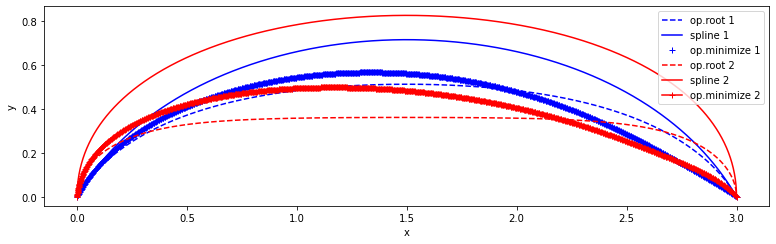

In [28]:
QV_sol1 = trajectories1.reshape(Nt, param.n_dim*2, param.n_nodes, order='F')
spline = cvsplines.reshape(Nt, param.n_dim*2, param.n_nodes, order='F')
QV_sol_min = sol_min_matrix.reshape(Nt, param.n_dim*2, param.n_nodes, order='F')

fig1, ax1 = plt.subplots(figsize=(13, 9))

# for n in range(Nt):
#     ax1.plot(QV_sol1[n,0,:],QV_sol1[n,1,:],color='blue')
#     ax1.plot(spline[n,0,:],spline[n,1,:],color='red')
#     ax1.plot(QV_sol_min[n,0,:],QV_sol_min[n,1,:],'-',color='green')

ax1.plot(QV_sol1[0,0,:],QV_sol1[0,1,:],'--', color='blue', label = 'op.root 1')
ax1.plot(spline[0,0,:],spline[0,1,:],'-', color='blue', label = 'spline 1')
ax1.plot(QV_sol_min[0,0,:],QV_sol_min[0,1,:],'+',color='blue', label = 'op.minimize 1')
ax1.plot(QV_sol1[1,0,:],QV_sol1[1,1,:],'--', color='red', label = 'op.root 2')
ax1.plot(spline[1,0,:],spline[1,1,:],'-', color='red', label = 'spline 2')
ax1.plot(QV_sol_min[1,0,:],QV_sol_min[1,1,:],'-+',color='red', label = 'op.minimize 2')
ax1.set_aspect('equal')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [19]:
# fig1.savefig(f'/Users/ergysc/Documents/GitHub/beam_NN/101nodes_5000iter_new.pdf')